## What is LangGraph?
LangGraph is a library built on top of LangChain, designed to add cyclic computational capabilities to your LLM applications. While LangChain allows you to define chains of computation (Directed Acyclic Graphs or DAGs), LangGraph introduces the ability to add cycles, enabling more complex, agent-like behaviors where you can call an LLM in a loop, asking it what action to take next.

The aim of LangGraph is to have level of control when it comes to executing autonomous AI agents.


<img src="../assets/imgs/langgraph.bmp" width=800></img>



## Key Concepts
* Stateful Graph: LangGraph revolves around the concept of a stateful graph, where each node in the graph represents a step in your computation, and the graph maintains a state that is passed around and updated as the computation progresses.  It ensures that each step in the graph can access relevant information from previous steps, allowing for dynamic decision-making based on accumulated data throughout the process.
* Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. **You define nodes to perform specific tasks, such as processing input, making decisions, or interacting with external APIs.**
* Edges: Edges connect the nodes in your graph, defining the flow of computation. LangGraph supports **conditional edges**, allowing you to dynamically determine the next node to execute based on the current state of the graph.



## A Simple Example
Let’s walk through a simple example where we use LangGraph to classify user input as either a “greeting” or a “search” query and respond accordingly.

Step 1: Define the Graph State
First, we define the state structure for our graph. In this example, our state includes the user’s question, the classification of the question, and a response.

### Step 1: Define the Graph State
First, we define the state structure for our graph. In this example, our state includes the user’s question, the classification of the question, and a response.

In [47]:
from typing import Dict, TypedDict, Optional

class GraphState(TypedDict):
    question: Optional[str] = None
    classification: Optional[str] = None
    response: Optional[str] = None

### Step 2: Create the Graph
Next, we create a new instance of StateGraph with our GraphState structure.

In [48]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(GraphState)



### Step 3: Define Nodes
We define nodes for classifying the input, handling greetings, and handling search queries.


In [49]:
def classify(question):
    return question.upper()

def classify_input_node(state):
    question = state.get('question', '').strip()
    classification = classify(question)  # Assume a function that classifies the input
    return {"classification": classification}

def handle_greeting_node(state):
    return {"response": "Hello! How can I help you today?"}

def handle_search_node(state):
    question = state.get('question', '').strip()
    search_result = f"Search result for '{question}'"
    return {"response": search_result}

### Step 4: Add Nodes to the Graph
We add our nodes to the graph and define the flow using edges and conditional edges.

In [50]:
CLASSIFY = 'classify_input'
GREETING = 'handle_greeting'
SEARCH = 'handle_search'


workflow.add_node(CLASSIFY, classify_input_node)
workflow.add_node(GREETING, handle_greeting_node)
workflow.add_node(SEARCH, handle_search_node)

def decide_next_node(state: GraphState):
    return GREETING if state.get('classification') == "GREETING" else SEARCH

workflow.add_conditional_edges(
    CLASSIFY,
    decide_next_node,
    {
        GREETING: "handle_greeting",
        SEARCH: "handle_search"
    }
)    

### Step 5: Set Entry and End Points
We set the entry point for our graph and define the end points.

In [51]:
workflow.set_entry_point(CLASSIFY)
workflow.add_edge(GREETING, END)
workflow.add_edge(SEARCH, END)

### Step 6: Compile and Run the Graph
Finally, we compile our graph and run it with some input.

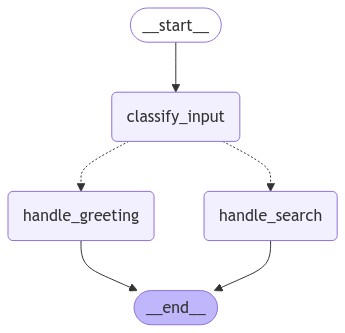

{'question': 'greeting', 'classification': 'GREETING', 'response': 'Hello! How can I help you today?'}


In [52]:
from IPython.display import Image, display

app = workflow.compile()

display(Image(app.get_graph().draw_mermaid_png()))

inputs = {"question": "greeting"}
result = app.invoke(inputs)
print(result)

## Build a Basic Chatbot

### Part 1
Start by creating a StateGraph. A StateGraph object defines the structure of our chatbot as a "state machine". We'll add nodes to represent the llm and functions our chatbot can call and edges to specify how the bot should transition between these functions.

In [53]:
from typing import Annotated, TypedDict

from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import add_messages

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]
    
    
graph_builder = StateGraph(State)

So now our graph knows two things:

*  very node we define will receive the current State as input and return a value that updates that state.  
* messages will be appended to the current list, rather than directly overwritten. This is communicated via the prebuilt add_messages function in the Annotated syntax.  
Next, add a "chatbot" node. Nodes represent units of work. They are typically regular python functions.

In [54]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

Notice how the chatbot node function takes the current State as input and returns a dictionary containing an updated messages list under the key "messages". This is the basic pattern for all LangGraph node functions.

The add_messages function in our State will append the llm's response messages to whatever messages are already in the state.

Next, add an entry point. This tells our graph where to start its work each time we run it.

In [55]:

graph_builder.add_edge(START, "chatbot")

graph_builder.add_edge("chatbot", END)

Finally, we'll want to be able to run our graph. To do so, call "compile()" on the graph builder. This creates a "CompiledGraph" we can use invoke on our state.

In [56]:
graph = graph_builder.compile()

In [57]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

stream_graph_updates('ola')

Assistant: Olá! Como posso ajudar você hoje?


Referencias  
* https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141
* https://cobusgreyling.medium.com/langgraph-from-langchain-explained-in-simple-terms-f7cd0c12cdbf
* https://medium.com/@lorevanoudenhove/how-to-build-ai-agents-with-langgraph-a-step-by-step-guide-5d84d9c7e832
* 